In [117]:
import time
import datetime
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException  
from selenium.webdriver.support.ui import Select


def init_system(path_to_chromedriver):
    #reload(sys)
    #sys.setdefaultencoding('utf-8')
    driver = init_driver(path_to_chromedriver)
    return driver

def init_driver(path):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--no-sandbox')
    #chrome_options.add_argument('--proxy-server=107.174.48.114:8989')
    chrome_options.add_argument("--start-maximized");
    browser = webdriver.Chrome(executable_path = path,chrome_options=chrome_options)
    return browser

def generate_consecutive_dates(start_date,end_date,interval):
    start_date = [int(x) for x in start_date.split('-')]
    end_date =  [int(x) for x in end_date.split('-')]
    dt = datetime.datetime(int(start_date[0]), int(start_date[1]), start_date[2])
    end = datetime.datetime(end_date[0], end_date[1], end_date[2])
    step = datetime.timedelta(days=interval)
    result = []
    while dt < end:
        result.append(dt.strftime('%m/%d/%Y'))
        dt += step
    return result

def scrape_page(driver,date,t,columns):
    wait_date = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.ID, "wait-times-date")))
    wait_date.clear()
    wait_date.send_keys(date)
    wait_date.send_keys(Keys.RETURN);

    select = Select(driver.find_element_by_id('wait-times-hour'))
    select.select_by_value(t)
    submit = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.ID, "lookup-wait-times")))
    submit.send_keys(Keys.RETURN)
    
    index = []
    WebDriverWait(driver, 20).until(EC.text_to_be_present_in_element((By.ID, "wait-times-legend"), "Approximate security wait times"))
    wait_table = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.ID, "wait-times-table")))
    index =[date+ " "+str(a.text) for a in wait_table.find_elements_by_xpath("li[1]//div//span")]
    wait_list = wait_table.find_elements_by_tag_name("li")
    output =[]
    for item in wait_list:
        menu = item.find_elements_by_xpath("div//span")
        out = []
        for e in menu:
            out.append(e.get_attribute("class"))
        output.append(out)
    
    return pd.DataFrame(output,columns=columns,index=index)

In [104]:
path_to_chromedriver = './chromedriver'
url = 'http://www.ifly.com/john-f-kennedy-international-airport/wait-times'
date = "10/08/2017"
timeslots = ["00:00","04:00","08:00","12:00","16:00","20:00"]
columns = ["Terminal 1 Gates 1 - 10","Terminal 2 Gates 19 - 29","Terminal 4 Gates A2- A7","Terminal 4 Gates B20 - B31","Terminal 5 Gates 1 - 25","Terminal 7 Gates 1 - 12","Terminal 7 Gates 1 - 12","Terminal 8 Gates 1 - 47"]
start_dt = "2017-09-14"
end_dt =  "2017-10-12"

In [105]:
driver = init_system(path_to_chromedriver)
driver.get(url)

In [106]:
df = pd.DataFrame()
for date in generate_consecutive_dates(start_dt,end_dt,1): 
    for t in timeslots:
        df= df.append(scrape_page(driver,date,t,columns))

In [314]:
out_df = df.applymap(lambda x:int(x.split("-")[2]))
out_df.to_csv("Terminal_"+start_dt+"_"+end_dt+".csv")

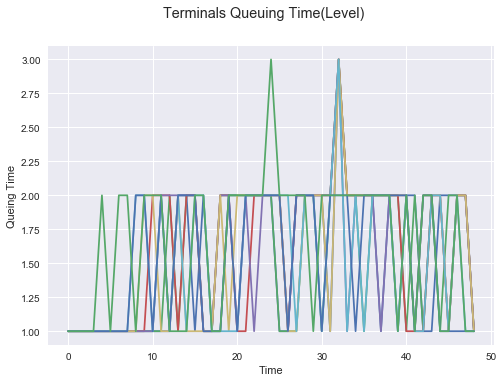

In [316]:
fig = plt.figure()
plt.plot(out_df.ix[:49,0:].values)
fig.suptitle('Terminals Queuing Time(Level)')
plt.xlabel('Time')
plt.ylabel('Queing Time')
plt.show()